In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
from mixture_density_nets import MDN, MDDistribution
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

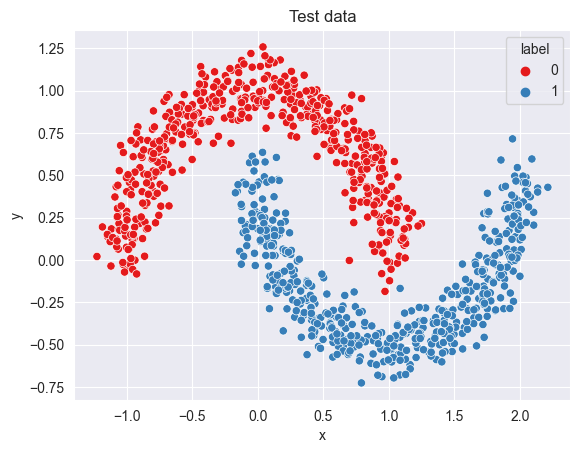

In [92]:
train_data, train_labels = make_moons(n_samples=5000, noise=0.1, shuffle=True)
test_data, test_labels = make_moons(n_samples=1000, noise=0.1, shuffle=True)
sns.scatterplot(data=pd.DataFrame({'x': test_data[:, 0],
                                   'y': test_data[:, 1],
                                   'label': test_labels}),
              x='x', y='y', hue='label', palette='Set1')
plt.title('Test data')
plt.show()

In [93]:
class MDNMLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hdim=64, p_drop=0.15, n_components=4):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(in_dim, hdim),
            nn.Dropout(p_drop),
            nn.LeakyReLU(),
            nn.Linear(hdim, hdim),
            nn.Dropout(p_drop),
            nn.LeakyReLU(),
            nn.ReLU()
        )
        self.mdn = MDN(hdim, out_dim, n_components)

    def forward(self, x):
        out = self.trunk(x)
        return self.mdn(out)

In [104]:
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(train_data).float(),
                                      torch.from_numpy(train_labels)),
                        batch_size=128, shuffle=True)
mlp = MDNMLP(n_components=4)
optimizer = optim.Adam(mlp.parameters(), lr=2e-3)

In [105]:
for epoch in range(42):
    epoch_loss = []
    for batch in train_dataloader:
        xy, l = batch
        x, y = xy[:, 0, None], xy[:, 1, None]
        mu, sigma, lambda_logits = mlp(x)
        loss = MDDistribution(mu, sigma, lambda_logits).nll(y).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    print(f'Loss in epoch {epoch+1}: {np.mean(epoch_loss):.3f}')

Loss in epoch 1: 0.654
Loss in epoch 2: 0.441
Loss in epoch 3: 0.316
Loss in epoch 4: 0.244
Loss in epoch 5: 0.199
Loss in epoch 6: 0.171
Loss in epoch 7: 0.146
Loss in epoch 8: 0.151
Loss in epoch 9: 0.125
Loss in epoch 10: 0.106
Loss in epoch 11: 0.101
Loss in epoch 12: 0.082
Loss in epoch 13: 0.066
Loss in epoch 14: 0.063
Loss in epoch 15: 0.066
Loss in epoch 16: 0.058
Loss in epoch 17: 0.036
Loss in epoch 18: 0.038
Loss in epoch 19: 0.050
Loss in epoch 20: 0.035
Loss in epoch 21: 0.027
Loss in epoch 22: 0.031
Loss in epoch 23: 0.011
Loss in epoch 24: 0.015
Loss in epoch 25: 0.018
Loss in epoch 26: 0.007
Loss in epoch 27: 0.036
Loss in epoch 28: 0.014
Loss in epoch 29: 0.002
Loss in epoch 30: 0.007
Loss in epoch 31: 0.006
Loss in epoch 32: 0.011
Loss in epoch 33: -0.001
Loss in epoch 34: 0.000
Loss in epoch 35: 0.006
Loss in epoch 36: 0.005
Loss in epoch 37: 0.009
Loss in epoch 38: -0.009
Loss in epoch 39: -0.000
Loss in epoch 40: -0.012
Loss in epoch 41: 0.012
Loss in epoch 42: 0.0

In [106]:
test_mdn_out = mlp(
    torch.from_numpy(test_data)[:, 0, None].float()
)
n_samples = 4
samples, clusters = MDDistribution(*test_mdn_out).sample(n=n_samples)

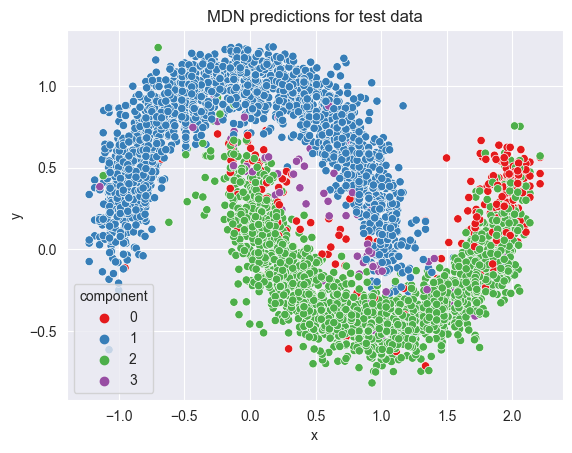

In [107]:
samples = samples.flatten()
clusters = clusters.flatten()

sns.scatterplot(data=pd.DataFrame({
    'x': test_data[:, 0].repeat(n_samples),
    'y': samples,
    'component': clusters
    }), x='x', y='y', hue='component', palette='Set1'
)
plt.title('MDN predictions for test data')
plt.show()